<a href="https://colab.research.google.com/github/xqyn/BI-BE-CS-183-2023-HW/blob/main/HW1/Problem3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bi/Be/Cs 183 2022-2023: Intro to Computational Biology
TAs: Meichen Fang, Tara Chari, Zitong (Jerry) Wang

**Submit your notebooks by sharing a clickable link with Viewer access. Link must be accessible from submitted assignment document.**

Make sure Runtime $\rightarrow$ Restart and run all works without error

**HW 1 Problem 3**

For this problem you will be exploring the phenomenon known as Simpson's Reversal in a single-cell sequencing dataset.

As described in Lecture, Simpson's Reversal describes the phenomenon where a certain trend appears within certain groups of the data, but disappears or is reversed when the groupings are changed. One of the advantages of single-cell RNA sequencing as opposed to bulk RNA sequencing (where all reads from all cells are pooled together) is that it provides the opportunity, in principle, to avoid incorrect inferences about correlation between pairs of genes.

For this problem you will mine a single-cell RNA-seq dataset to see if this phenomenon occurs in practice.

In [ ]:
#To run a code cell, select the cell and hit Command/Ctrl+Enter or click the run/play symbol
#Click Insert --> Code Cell or the '+ Code' option to insert a new code cell

In [ ]:
#Click Insert --> Text Cell or the '+ Text' option to insert a cell for text as below

In [1]:
# This is  used to time the running of the notebook
import time
start_time = time.time()

Text here for descriptions, explanations, etc

##**Import data and install packages**

In [2]:
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt #Can use other plotting packages like seaborn

In [3]:
#Download count matrix of cell by gene counts and metadata files, DOI: 10.22002/D1.20031

import requests
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
    url = 'https://api.datacite.org/dois/'+doi+'/media'
    r = requests.get(url).json()
    netcdf_url = r['data'][0]['attributes']['url']
    r = requests.get(netcdf_url,stream=True)
    #Set file name
    fname = doi.split('/')[-1]+ext
    #Download file with progress bar
    if r.status_code == 403:
        print("File Unavailable")
    if 'content-length' not in r.headers:
        print("Did not get file")
    else:
        with open(fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            pbar = tnrange(int(total_length/1024), unit="B")
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    pbar.update()
                    f.write(chunk)
        return fname

download_file('10.22002/D1.20031','.tar.gz')

!tar -xvf D1.20031.tar.gz

<ipython-input-3-07df2730af8c>:20: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  pbar = tnrange(int(total_length/1024), unit="B")


  0%|          | 0/6617 [00:00<?, ?B/s]

._cell_metadata.csv
cell_metadata.csv
._gene_metadata.csv
gene_metadata.csv
._exutero.mtx
exutero.mtx


## **Read in data for analysis**

**The dataset**

Much of mammalian embryo development occurs after the embryo implants in the uterus, however this makes the embryo relatively inaccessible and thus hard to study. In [Aguilera-Castrejon et al., 2021](https://www.nature.com/articles/s41586-021-03416-3#Sec7), a cell culture platform was established to culture post-implantation embryos ex utero (outside the uterus) from pre-gastrulation until himdlimb formation (organogenesis).  Single-cell sequencing was done for both in utero and ex utero cultured mouse embryos, to compare development of the externally cultured cells.

<center><img src="https://drive.google.com/uc?export=view&id=1b6BM_W5Nk2r31RdGE7-bKDuObQq279qh" alt="EMFigure" width="800" height="350"><center>


**The count matrix**

This matrix is 6,205 cells by 2,000 genes. We are only working with the ex-utero cultured mouse embryo cells here.

1.   For each cell, gene counts were normalized to have the same number of total counts (usually 1e5 or 1e6), with cell-gene counts thus scaled accordingly.

2.   Counts were then log-normalized, using the log(1+x), where x is each cell's gene count. The 1 accounts for 0 count genes.

3. The top ~2000 genes were selected for those that displayed large variance in expression amongst the cells ('highly variable genes').



In [4]:
#Get gene count matrix
count_mat = sio.mmread('exutero.mtx')
count_mat.shape

(6205, 2000)

In [5]:
#Get metadata dataframe for the 6,205 cells (rows of the matrix)
meta = pd.read_csv('cell_metadata.csv',index_col = 0)
meta.head()

,cell_type
AAACCCAAGTACAACA-3,Mixed Mesoderm
AAACCCAGTACACTCA-3,Blood
AAACCCATCGAAGCAG-3,Neural Tube
AAACGAAAGGAAACGA-3,Mixed Mesoderm
AAACGAACACATGGTT-3,Pharyngeal Mesoderm


In [6]:
meta.iloc[:,0].value_counts()

Blood                       1104
Mixed Mesoderm               551
Endothelial                  547
Foregut                      510
Amnion                       443
Mid Hind Brain               429
Extra-Embryonic Endoderm     406
Placodes                     372
Presomitic Mesoderm          366
Pharyngeal Mesoderm          319
Cardiac                      317
Extra-Embryonic Ectoderm     284
Neural Tube                  216
Somitic Mesoderm             172
Neural Crest                  80
Extra-Embryonic Mesoderm      51
Mid Hind Gut                  38
Name: cell_type, dtype: int64

In [7]:
#Get metadata dataframe for the 2,000 genes (columns of the matrix)
meta_gene = pd.read_csv('gene_metadata.csv',index_col = 0)
meta_gene.head()

,gene_name
0,Sox17
1,Lypla1
2,Sgk3
3,Xkr9
4,Bag2


## **Problem 3 (36 points)**
Find an example of Simpson's reversal.

Generally Simpson's reversal describes how a trend may appear in several groups of data, but not exist or be reversed when groups are combined.

Here we will focus on trends of correlation, where two variables (genes) appear correlated in one direction (e.g. **positively**) given one set of groupings, but display **no or negative** correlation in another set of groupings.

For the purposes of this homework, we will be using the common Pearson correlation coefficient to measure correlation between variables.

This can be calculated using numpy's corrcoef() function in python, where correlation values are between -1 and 1.

In [8]:
#Use np.corrcoef()

#Given two lists/vectors of values x and y, np.corrcoef(x,y) will return a
#pairwise correlation matrix where the diagonal represent correlation between
#x with x or y with y, (which are 1) and the off-diagonals which both represent
#correlation of x with y.

#The off-diagonal value is the value we are interested in

x = [1.0,2.0,3.0,4.0]
y = [4.0,5.0,2.0,6.0]

corrs = np.corrcoef(x,y)
print('Correlation matrix: \n', corrs)

print('Corr in first row, second column: ', corrs[0,1])

Correlation matrix: 
 [[1.         0.22677868]
 [0.22677868 1.        ]]
Corr in first row, second column:  0.22677868380553634


**Problem:** Find two genes which display a Simpson's reversal in their correlations depending on how they are grouped. We are calculating correlation between the genes' expression vectors i.e. their values across cells.

Examples of grouping comparison include, but are not limited to:

*   Correlation of two genes within each one of two cell types versus their correlations within the two cell types (no cell type grouping)
*   Correlation of two genes within one cell type versus their correlation across all cells (no cell type grouping)


*Try to report the most extreme difference in correlation you can find*

Show:

a.   All code for subsetting the count matrix and calculating correlation values for a pair of genes. (12 points)

Code can be added to code cells below. Feel free to add more code cells if necessary.






In [9]:
# ------- Example code for finding gene-pair correlations within a cell type versus across all cells -----------

gene1 = 'Krt8' # Keratin 8 is a member of the type II keratin family
gene2 = 'Hmgn5'  #High Mobility Group Nucleosome Binding Domain 5

indices = meta['cell_type'].isin(['Mid Hind Gut']) #Get indices for where the cell_type is Blood only

g1_indices = meta_gene['gene_name'].tolist().index(gene1) #Get exact index for where gene names are gene1 only
g2_indices = meta_gene['gene_name'].tolist().index(gene2)

#Correlation of counts within cell type
count_sub_g1 = count_mat[indices,g1_indices] #Filter rows (cells) of matrix
count_sub_g2 = count_mat[indices,g2_indices]

corrs = np.corrcoef(count_sub_g1,count_sub_g2)
print('Correlation within type: ', corrs[0,1])

#Correlation of counts within cell type
count_all_g1 = count_mat[:,g1_indices] #Filter rows (cells) of matrix Sntg1
count_all_g2 = count_mat[:,g2_indices]

corrs = np.corrcoef(count_all_g1,count_all_g2)
print('Correlation across all cells: ',corrs[0,1])

#We see positive correlation within the Mid Hind Gut cell type but small correlation across all cells

Correlation within type:  0.43329374882242444
Correlation across all cells:  0.07308318924730003


In [10]:
# ------- Your code below -------

In [54]:
# ------- Example code for finding gene-pair correlations within a cell type versus across all cells -----------
from numpy import random
d = []
for cell_type in meta['cell_type'].tolist():
  for i in range(10):
    # set random
    #print('Run' + str(i) + '----------------------------------------------------------')
    rd1 = random.randint(meta_gene.shape[0])
    rd2 = random.randint(meta_gene.shape[0])
    # gene of random
    gene1 = meta_gene.iloc[rd1][0]
    gene2 = meta_gene.iloc[rd2][0]

    #print('gene1: ' + gene1)
    #print('gene2: ' + gene2)
    #print('cell_type: ' + cell_type)
    indices = meta['cell_type'].isin([cell_type]) #Get indices for where the cell_type is Blood only
    g1_indices = meta_gene['gene_name'].tolist().index(gene1) #Get exact index for where gene names are gene1 only
    g2_indices = meta_gene['gene_name'].tolist().index(gene2)

    #Correlation of counts within cell type
    count_sub_g1 = count_mat[indices,g1_indices] #Filter rows (cells) of matrix
    count_sub_g2 = count_mat[indices,g2_indices]

    if np.count_nonzero(count_sub_g2) != 0 and np.count_nonzero(count_sub_g2) != 0:
      corrs1 = np.corrcoef(count_sub_g1,count_sub_g2)[0,1]
      #print('Correlation within type: ', corrs1[0,1])
      #Correlation of counts within cell type
      count_all_g1 = count_mat[:,g1_indices] #Filter rows (cells) of matrix Sntg1
      count_all_g2 = count_mat[:,g2_indices]
      corrs2 = np.corrcoef(count_all_g1,count_all_g2)[0,1]
      #print('Correlation across all cells: ',corrs2[0,1])
      #print('DELTA: ', abs(abs(abs(corrs2[0,1]) - abs(corrs1[0,1]))))
      d.append([cell_type, gene1, gene2, corrs1, corrs2])
      # if abs(abs(abs(corrs2[0,1]) - abs(corrs1[0,1]))) > corr_delta:
      #   gene1_delta = gene1
      #   gene2_delta = gene2
      #   cell_type_delta = cell_type
      #   corr_delta1 = corrs1[0,1]
      #   corr_delta2 = corrs2[0,1]
      #   corr_delta = abs(abs(abs(corrs2[0,1]) - abs(corrs1[0,1])))
      #continue
    #print('contain NAN')
    #We see positive correlation within the Mid Hind Gut cell type but small correlation across all cells

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [86]:
df = pd.DataFrame(np.vstack(d))
df.columns = ['cell_type', 'gene_1',' gene_2', 'corr_group', 'corr_all']
 # remove nan row
#df['corr_group'].astype(float)
df['corr_group'] = df['corr_group'].astype(float)
df['corr_all'] = df['corr_all'].astype(float)
df.loc[df['corr_group'] != 'nan',]
df.dropna(axis=0, inplace=True)

In [90]:
df['corr_delta'] = abs(abs(df['corr_group']) - abs(df['corr_all']))
df.loc[df['corr_delta'] == max(df['corr_delta'])]

,cell_type,gene_1,gene_2,corr_group,corr_all,corr_delta
725,Blood,Gstp3,Gip,1.0,0.015839,0.984161


In [134]:
indices = meta['cell_type'].isin(['Blood'])

g1_indices = meta_gene['gene_name'].tolist().index('Gstp3')
g2_indices = meta_gene['gene_name'].tolist().index('Gip')


In [150]:
df_count_mat = pd.DataFrame(count_mat)
df_count_mat.iloc[indices.values,[g1_indices,g2_indices]]

,1917,1429
1,0.0,0.0
6,0.0,0.0
7,0.0,0.0
10,0.0,0.0
16,0.0,0.0
...,...,...
6192,0.0,0.0
6194,0.0,0.0
6199,0.0,0.0
6200,0.0,0.0


from matplotlib import pyplot as plt
_df_0[1917].plot(kind='hist', bins=20, title=1917)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1[1429].plot(kind='hist', bins=20, title=1429)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x=1917, y=1429, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3[1917].plot(kind='line', figsize=(8, 4), title=1917)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4[1429].plot(kind='line', figsize=(8, 4), title=1429)
plt.gca().spines[['top', 'right']].set_visible(False)

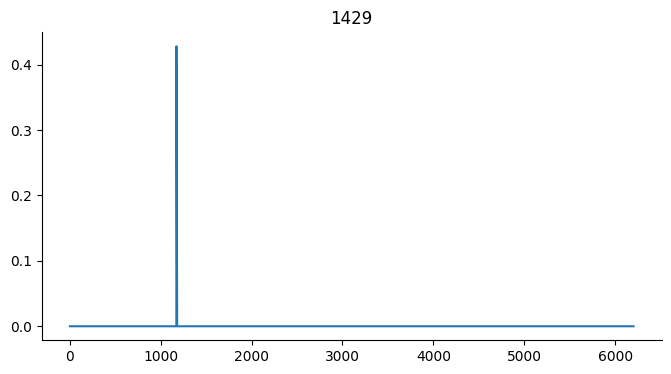

In [152]:
from matplotlib import pyplot as plt
_df_4[1429].plot(kind='line', figsize=(8, 4), title=1429)
plt.gca().spines[['top', 'right']].set_visible(False)

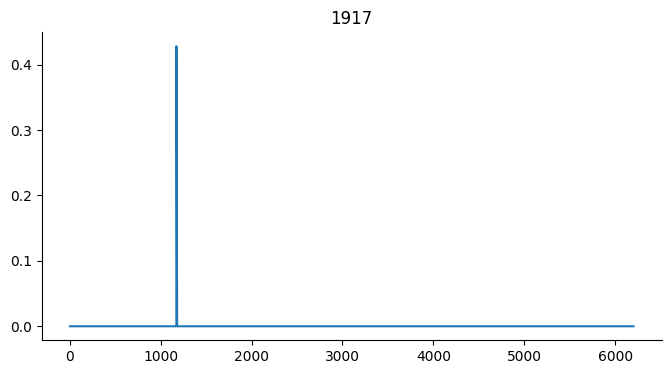

In [151]:
from matplotlib import pyplot as plt
_df_3[1917].plot(kind='line', figsize=(8, 4), title=1917)
plt.gca().spines[['top', 'right']].set_visible(False)

Report:

b.   What the comparison groupings are (e.g. within one cell type versus across all cells) (6 points)

c.   Which two genes you are looking at (6 points)

d.   What the gene-gene correlations are in each grouping (6 points)

e.   Qualitatively comment on how significant or relevant you think these correlation differences are, given the groupings you chose and the correlation values. (6 points)

*Answers b-e can be added directly to this text box*


In [ ]:
# Report:

# b.   What the comparison groupings are (e.g. within one cell type versus across all cells) (6 points)
# Blood
# c.   Which two genes you are looking at (6 points)
#Gstp3	Gip
# d.   What the gene-gene correlations are in each grouping (6 points)
#1
# e.   Qualitatively comment on how significant or relevant you think these correlation differences are, given the groupings you chose and the correlation values. (6 points)

# *Answers b-e can be added directly to this text box*


In [153]:
df.loc[df['corr_delta'] == max(df['corr_delta'])]

,cell_type,gene_1,gene_2,corr_group,corr_all,corr_delta
725,Blood,Gstp3,Gip,1.0,0.015839,0.984161


In [ ]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

0.50 minutes
